## Preprocess Data

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot  as plt
import seaborn as sns

# Load the data from the CSV files
base_info = pd.read_csv('base_info.csv')
base_pagamentos = pd.read_csv('base_pagamentos_desenvolvimento.csv')
base_cadastral = pd.read_csv('base_cadastral.csv')

# lower case all column names
base_info.columns = base_info.columns.str.lower()
base_pagamentos.columns = base_pagamentos.columns.str.lower()
base_cadastral.columns = base_cadastral.columns.str.lower()

# give a new id to each client based on registrartion date order
base_cadastral = base_cadastral.sort_values('data_cadastro').reset_index(drop=True)
base_cadastral['new_id'] = range(1, len(base_cadastral) + 1)

# save a corresponding dictionary of old_id and new_id
id_dict = base_cadastral[['id_cliente', 'new_id']].set_index('id_cliente').to_dict()

# convert str to date
def convert_date(df, to_date_columns, format):
  df_copy = df.copy()
  for col in to_date_columns:
    df_copy[col] = pd.to_datetime(df_copy[col], format=format)#.dt.date
  return df_copy

date_columns = ['data_emissao_documento', 'data_pagamento', 'data_vencimento']
base_pagamentos_date = convert_date(base_pagamentos, date_columns, '%Y-%m-%d')
base_pagamentos_date = convert_date(base_pagamentos_date, ['safra_ref'], '%Y-%m')
base_info_date = convert_date(base_info, ['safra_ref'], '%Y-%m')
base_cadastral_date = convert_date(base_cadastral, ['data_cadastro'], '%Y-%m-%d')

# ajust values in base_cadastral
base_cadastral_date.flag_pf = (base_cadastral_date.flag_pf == 'X').astype(int)
base_cadastral_date.segmento_industrial = base_cadastral_date.segmento_industrial.fillna('NAN')
base_cadastral_date.dominio_email = base_cadastral_date.dominio_email.fillna('NAN')
base_cadastral_date.porte = base_cadastral_date.porte.fillna('NAN')
base_cadastral_date.cep_2_dig = base_cadastral_date.cep_2_dig.fillna('NA')
base_cadastral_date.ddd = base_cadastral_date.ddd.fillna('-1')
base_cadastral_date.loc[base_cadastral_date['ddd'].str.contains("\("), 'ddd'] = '-2'

# Add a binary column, fraud, to base_pagamentos_desenvolvimento_coherent and assing 1 to rows where DATA_PAGAMENTO > DATA_VENCIMENTO + 5
base_pagamentos_date['late_payment'] = (base_pagamentos_date['data_pagamento'] - base_pagamentos_date['data_vencimento']).dt.days
base_pagamentos_date['fraud'] = np.where(base_pagamentos_date['late_payment'] > 5, 1, 0)

In [2]:
## base_cadastral encodings

# date encoding
def encode_date(df, columns):
    df_copy = df.copy()
    for col in columns:
        min_date = df_copy[col].min()
        df_copy[col + '_since_min'] = (df_copy[col] - min_date).dt.days + 1
        # df_copy[col + '_year'] = df_copy[col].dt.year
        # df_copy[col + '_month'] = df_copy[col].dt.month
        # df_copy[col + '_day'] = df_copy[col].dt.day
        # df_copy[col + '_dayofweek'] = df_copy[col].dt.dayofweek
        # df_copy[col + '_dayofyear'] = df_copy[col].dt.dayofyear
        # df_copy[col + '_weekofyear'] = df_copy[col].dt.weekofyear
        # df_copy[col + '_quarter'] = df_copy[col].dt.quarter
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

# One-hot encoding for categorical variables
def encode_categorical(df, columns):
    df_copy = df.copy()
    for col in columns:
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[col], prefix=col)], axis=1)
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

# ordinal encoding for categorical variables
def encode_ordinal(df, columns, mapping):
    df_copy = df.copy()
    for i, col in enumerate(columns):
        df_copy[col + '_encoded'] = df_copy[col].map(mapping[i])
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

ordinal_encode_map = [{'NAN': 0, 'PEQUENO': 1, 'MEDIO': 2, 'GRANDE': 3}]
base_cadastral_date_encoded = encode_date(base_cadastral_date, ['data_cadastro'])
base_cadastral_one_hot_encoded = encode_categorical(base_cadastral_date_encoded, ['segmento_industrial', 'dominio_email'])
base_cadastral_ordinal_encoded = encode_ordinal(base_cadastral_one_hot_encoded, ['porte'], ordinal_encode_map)
base_cadastral_droped = base_cadastral_ordinal_encoded.drop(['id_cliente', 'ddd', 'cep_2_dig'], axis=1)
base_cadastral_droped

# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
base_cadastral_scaled = scaler.fit_transform(base_cadastral_droped)
base_cadastral_scaled = pd.DataFrame(base_cadastral_scaled, columns=base_cadastral_droped.columns)
# display(base_cadastral_scaled.head())

In [3]:
# # visualization of the data
# from sklearn.manifold import TSNE
# base_cadastral_tsne = TSNE(n_components=3).fit_transform(base_cadastral_scaled)
# print(base_cadastral_tsne.shape)

# # plot 16 TSNEs with different columns as color
# fig = plt.figure(figsize=(20, 20))
# for i, col in enumerate(base_cadastral_scaled.columns):
#     ax = fig.add_subplot(4, 4, i+1, projection='3d')
#     ax.scatter(base_cadastral_tsne[:, 0], 
#                base_cadastral_tsne[:, 1], 
#                base_cadastral_tsne[:, 2], 
#                c=base_cadastral_scaled[col], 
#                cmap='coolwarm')
#     plt.title(col)
# plt.show()

# base_cadastral_tsne_df = pd.DataFrame(base_cadastral_tsne, columns=['tsne_1', 'tsne_2', 'tsne_3'])

## Encoding (compressing) client information from base_cadastral from 15 to 3 dimentions.

In [4]:
histories = []

In [5]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

def create_layers(input_layer, units, activation='relu', dropout_rate=0.1):
    x_dense = Dense(units, activation=activation)(input_layer)
    x_bn = BatchNormalization()(x_dense)
    x_drop = Dropout(dropout_rate)(x_bn)
    return [x_dense, x_bn, x_drop]

def autoencoder_model(input_dim, encoding_dim, learning_rate=0.002, weight_decay=0.0001):
    input_layer = Input(shape=(input_dim, ))

    # encoder
    encoder = create_layers(input_layer, 25)
    encoder = create_layers(encoder[2], 15)
    encoder = create_layers(encoder[2] + input_layer, 15)
    encoder_skip = create_layers(encoder[2], 15)
    encoder = create_layers(encoder_skip[2] + encoder[1], 15)
    encoded = Dense(encoding_dim, activation='linear')(encoder[2])

    # decoder
    decoder = create_layers(encoded, 15)
    decoder_skip = create_layers(decoder[2], 15)
    decoder = create_layers(decoder_skip[2] + decoder[1], 15)
    decoder = create_layers(decoder[2], 15)
    decoder = create_layers(decoder[2], 25)
    decoded = Dense(input_dim, activation='linear')(decoder[2])

    autoencoder = Model(inputs=input_layer, outputs=decoded)

    adam = Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    autoencoder.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

    return autoencoder

input_dim = base_cadastral_scaled.shape[1]
encoding_dim = 3

# base_cadastral_train_eval = base_cadastral_scaled.iloc[0:int(len(base_cadastral_scaled)*0.85), :]
# base_cadastral_test = base_cadastral_scaled.iloc[int(len(base_cadastral_scaled)*0.85):, :]

autoencoder = autoencoder_model(input_dim, encoding_dim)
history = autoencoder.fit(base_cadastral_scaled, base_cadastral_scaled, epochs=100, batch_size=64, validation_split=0.2)

# autoencoder.evaluate(base_cadastral_test, base_cadastral_test)

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-18].output)
encoded_data = encoder.predict(base_cadastral_scaled)


2023-05-22 16:55:21.900532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:55:23.212182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 16:55:23.212265: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-22 16:55:25.848601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/100
17/17 [==============================] - 15s 69ms/step - loss: 2.0402 - mae: 1.0593 - val_loss: 1.1773 - val_mae: 0.7671
Epoch 2/100
17/17 [==============================] - 0s 25ms/step - loss: 1.4823 - mae: 0.8929 - val_loss: 1.1841 - val_mae: 0.7746
Epoch 3/100
17/17 [==============================] - 0s 28ms/step - loss: 1.2168 - mae: 0.8048 - val_loss: 1.1866 - val_mae: 0.7771
Epoch 4/100
17/17 [==============================] - 0s 24ms/step - loss: 1.1003 - mae: 0.7519 - val_loss: 1.1702 - val_mae: 0.7708
Epoch 5/100
17/17 [==============================] - 0s 25ms/step - loss: 1.0356 - mae: 0.7215 - val_loss: 1.1452 - val_mae: 0.7594
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 0.9577 - mae: 0.6880 - val_loss: 1.1162 - val_mae: 0.7462
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.9350 - mae: 0.6782 - val_loss: 1.0721 - val_mae: 0.7265
Epoch 8/100
17/17 [==============================] - 0s 18ms/step - loss: 0

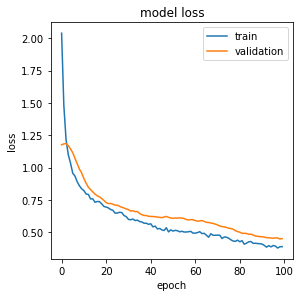

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 25)           400         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25)          100         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 25)           0           ['batch_normalization[0][0]

In [6]:
histories.append(history)

# plot losses
fig = plt.figure(figsize=(20, 20))
for i, history in enumerate(histories):
    ax = fig.add_subplot(4, 4, i+1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
plt.show()

# 1:  encoder 15, decoder 15, sigmoid
# 2:  encoder 15, decoder 15, linear
# 3:  encoder 10, 10, 3, decoder 10, 10, 15, sigmoid
# 4:  encoder 10, dropout, 10, dropout, 3, decoder 10, dropout, 10, dropout, 15, sigmoid
# 5:  encoder 10, dropout, 10, dropout, 3, decoder 10, dropout, 10, dropout, 15, linear
# 6:  encoder 15, dropout, 10, dropout, 10, dropout, 3, decoder 10, dropout, 10, dropout, 10, dropout, 15, linear, bach_size=64 (double)
# 7:  encoder 15, BN, dropout, 10, BN, dropout, 10, BN, dropout, 3, decoder 10, BN, dropout, 10, BN, dropout, 10, BN, dropout, 15, linear | 17: like 7 w_16 perks, but with BN an linear f. encoder yielded zero repeated representations, v_loss=0.58
# 8:  encoder 25, BN, dropout, 15, BN, dropout, 15, BN, dropout, 3, decoder 15, BN, dropout, 15, BN, dropout, 25, BN, dropout, 15, linear
# 9:  encoder 25, BN, dropout, 15, BN, dropout, 15, BN, dropout, 3, decoder 15, BN, dropout, 15, BN, dropout, 25, BN, dropout, 15, linear
# 10: encoder 25, BN, dropout, 15, BN, dropout, 15, BN, dropout, 3, decoder 15, BN, dropout, 15, BN, dropout, 25, BN, dropout, 15, linear (1/0 skip enc/dec) (double trainning)
# 11: enc.b 25, enc.b 15, enc.b 15, enc.b 15, enc.b 15, 3, dec.b 15, dec.b 15, dec.b 15, dec.b 25, 15, linear (2/1 skip enc/dec)
# 12: enc.b 25, enc.b 15, enc.b 15, enc.b 15, enc.b 15, 3, dec.b 15, dec.b 15, dec.b 15, dec.b 25, 15, linear (2/1 skip enc/dec) (double lr)
# 13: enc.b 25, enc.b 15, enc.b 15, enc.b 15, enc.b 15, 3, dec.b 15, dec.b 15, dec.b 15, dec.b 25, 15, linear (2/1 skip enc/dec) (L2 0.0001)
# 14: enc.b 25, enc.b 15, enc.b 15, enc.b 15, enc.b 15, 3, dec.b 15, dec.b 15, dec.b 15, dec.b 25, 15, linear (2/1 skip enc/dec) ???
# 15: enc.b 25, enc.b 25, enc.b 25, enc.b 25, enc.b 15, 3, dec.b 15, dec.b 25, dec.b 25, dec.b 25, 15, linear (2/1 skip enc/dec) (double depth, "double" units)
# 16: enc.b 25, enc.b 15, enc.b 15, enc.b 15, enc.b 15, 3, dec.b 15, dec.b 15, dec.b 15, dec.b 25, 15, linear (2/1 skip enc/dec) (13 but with linear act.fun. for last layer in the encoder) ==> yeilded 11 repeated representations

# # save the collection of histories to a file
# import pickle
# with open('histories.pickle', 'wb') as f:
#     pickle.dump(histories, f)

# # load the collection of histories from a file
# import pickle
# with open('histories.pickle', 'rb') as f:
#     histories_loaded = pickle.load(f)


# loss: 0.3269 - mae: 0.3568 - val_loss: 0.4145 - val_mae: 0.3445
# loss: 0.5927 - mae: 0.4031
encoder.summary()

42/42 [==============================] - 1s 5ms/step


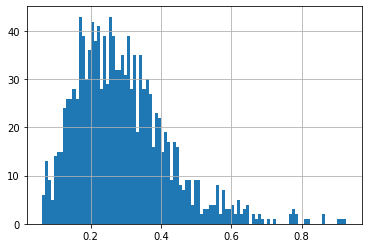

,id_cliente,data_cadastro,flag_pf,dominio_email,porte,new_id
segmento_industrial,,,,,,
Comércio,0.009281,0.009281,0.009281,0.009281,0.009281,0.009281
Indústria,0.026846,0.026846,0.026846,0.026846,0.026846,0.026846
NAN,0.253012,0.253012,0.253012,0.253012,0.253012,0.253012
Serviços,0.015905,0.015905,0.015905,0.015905,0.015905,0.015905


,id_cliente,data_cadastro,flag_pf,segmento_industrial,porte,new_id
dominio_email,,,,,,
AOL,0.081081,0.081081,0.081081,0.081081,0.081081,0.081081
BOL,0.264706,0.264706,0.264706,0.264706,0.264706,0.264706
GMAIL,0.005128,0.005128,0.005128,0.005128,0.005128,0.005128
HOTMAIL,0.015480,0.015480,0.015480,0.015480,0.015480,0.015480
NAN,0.233333,0.233333,0.233333,0.233333,0.233333,0.233333
OUTLOOK,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
YAHOO,0.015306,0.015306,0.015306,0.015306,0.015306,0.015306


,id_cliente,data_cadastro,segmento_industrial,dominio_email,porte,new_id
flag_pf,,,,,,
0,0.028823,0.028823,0.028823,0.028823,0.028823,0.028823
1,0.075758,0.075758,0.075758,0.075758,0.075758,0.075758


,id_cliente,data_cadastro,flag_pf,segmento_industrial,dominio_email,new_id
porte,,,,,,
GRANDE,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667
MEDIO,0.013410,0.013410,0.013410,0.013410,0.013410,0.013410
NAN,0.073171,0.073171,0.073171,0.073171,0.073171,0.073171
PEQUENO,0.040441,0.040441,0.040441,0.040441,0.040441,0.040441


In [7]:
# error analysis
decoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-1].output)
decoded_data = decoder.predict(base_cadastral_scaled)

decoded_data = pd.DataFrame(decoded_data, columns=base_cadastral_scaled.columns)
decoded_data['error'] = np.reshape(np.mean(np.abs(base_cadastral_scaled.values - decoded_data.values), axis=1), (-1, 1))

decoded_data['error'].hist(bins=100)
plt.show()

col = 'segmento_industrial'
base_cadastral_raw_drop = base_cadastral_date.drop(['ddd', 'cep_2_dig'], axis=1)
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('segmento_industrial').count() / base_cadastral_raw_drop.groupby('segmento_industrial').count())
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('dominio_email').count() / base_cadastral_raw_drop.groupby('dominio_email').count())
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('flag_pf').count() / base_cadastral_raw_drop.groupby('flag_pf').count())
display(base_cadastral_raw_drop[decoded_data['error'] > 0.6].groupby('porte').count() / base_cadastral_raw_drop.groupby('porte').count())

All encoded representations are unique.


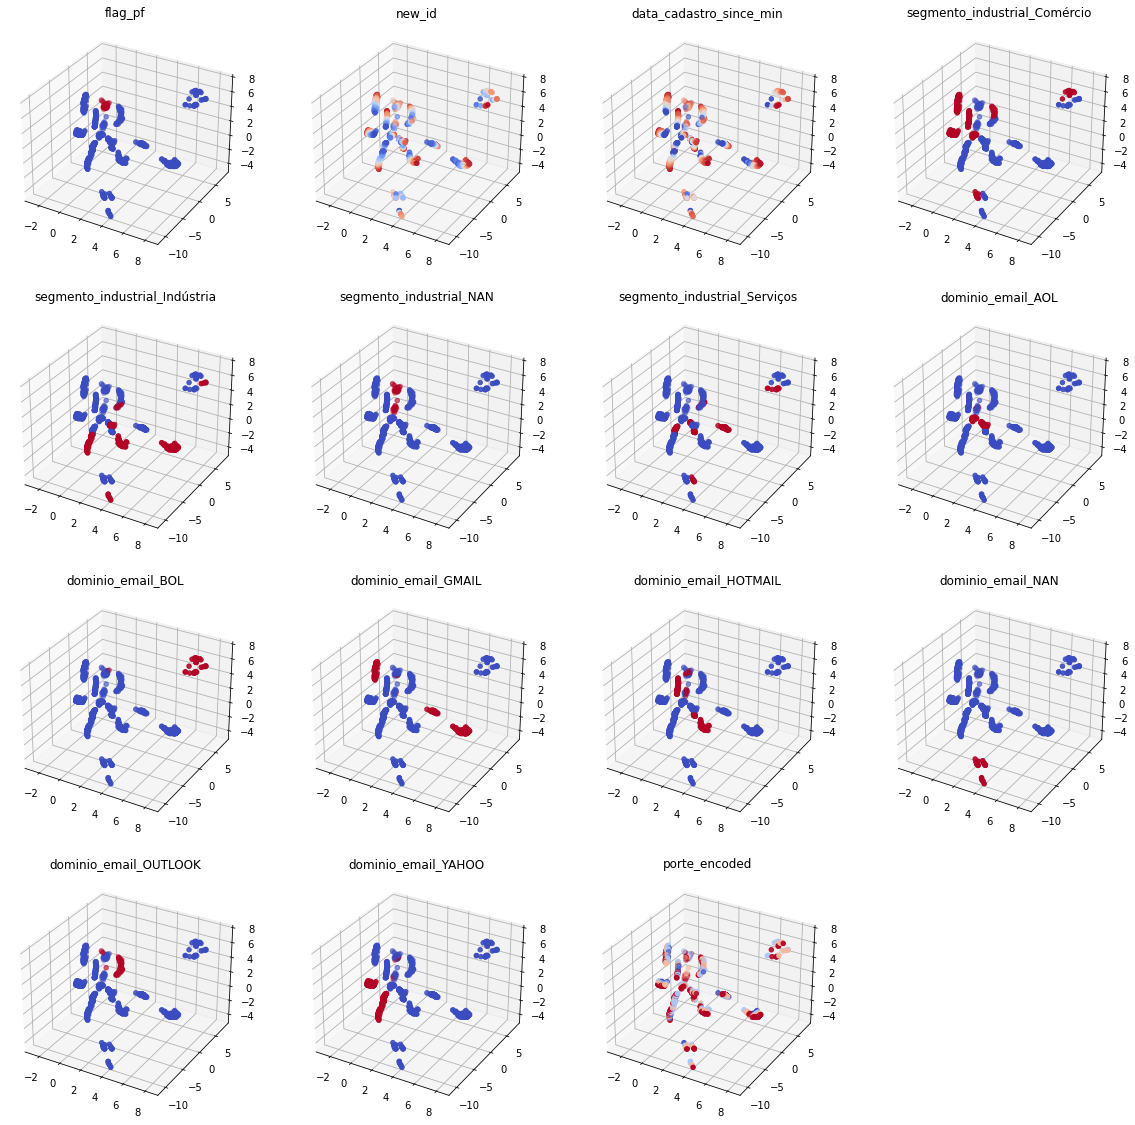

In [8]:
# check uniqueness of each encoded representation
encoded_data_df = pd.DataFrame(encoded_data, columns=['encoded_1', 'encoded_2', 'encoded_3'])
if encoded_data_df.groupby(['encoded_1', 'encoded_2', 'encoded_3']).size().shape[0] / encoded_data_df.shape[0]:
    print('All encoded representations are unique.')
else:
    print('There are repeated encoded representations.')
    print(encoded_data_df
            .groupby(['encoded_1', 'encoded_2', 'encoded_3'])
            .size()
            .reset_index()
            .rename(columns={0:'count'})
            .sort_values(by='count', ascending=False))


# check if the encoded data is separable unsing 16 plots
fig = plt.figure(figsize=(20, 20))
for i, col in enumerate(base_cadastral_scaled.columns):
    ax = fig.add_subplot(4, 4, i+1, projection='3d')
    ax.scatter(encoded_data_df['encoded_1'], encoded_data_df['encoded_2'], encoded_data_df['encoded_3'], c=base_cadastral_scaled[col], cmap='coolwarm')
    plt.title(col)
plt.show()

In [9]:
encoded_data_df['id_cliente'] = base_cadastral['id_cliente']
encoded_data_df

,encoded_1,encoded_2,encoded_3,id_cliente
0,1.956021,-1.743500,-1.131579,8437257970907722008
1,0.655462,0.039134,-0.569999,2179772649873197365
2,-0.395409,-2.388164,-1.245335,5692263270628375692
3,0.655579,0.039445,-0.570155,5611787644735474299
4,-1.483042,-1.615090,0.367890,2020646654269061959
...,...,...,...,...
1310,2.277552,4.756113,-2.258384,7742008298942700792
1311,-1.285524,0.257073,-2.783847,7720458526816091748
1312,-2.526189,-0.908367,-0.326235,2432667449154431819
1313,-2.554115,-0.800894,-0.144339,3183208564139585182


## Prepare for modeling

In [10]:
base_info_join = base_info_date.merge(encoded_data_df, on='id_cliente', how='inner')
base_join = base_info_join.merge(base_pagamentos_date, on=['id_cliente', 'safra_ref'], how='inner')
base_join_date_ordered = base_join.sort_values(by=['safra_ref'])

def encode_date(df, columns):
    df_copy = df.copy()
    for col in columns:
        min_date = df_copy[col].min()
        df_copy[col + '_since_min'] = (df_copy[col] - min_date).dt.days + 1
        # df_copy[col + '_year'] = df_copy[col].dt.year
        # df_copy[col + '_month'] = df_copy[col].dt.month
        # df_copy[col + '_day'] = df_copy[col].dt.day
        # df_copy[col + '_dayofweek'] = df_copy[col].dt.dayofweek
        # df_copy[col + '_dayofyear'] = df_copy[col].dt.dayofyear
        # df_copy[col + '_weekofyear'] = df_copy[col].dt.weekofyear
        # df_copy[col + '_quarter'] = df_copy[col].dt.quarter
        df_copy.drop(col, inplace=True, axis=1)
    return df_copy

base_join_date = encode_date(base_join_date_ordered, ['data_emissao_documento', 'data_pagamento', 'data_vencimento'])

X = base_join_date.drop(['id_cliente', 'safra_ref', 'late_payment', 'fraud'], axis=1)
y = base_join_date['fraud']

In [11]:
# import time series split
from sklearn.model_selection import KFold

# import bayesian optimization libraries
from skopt import BayesSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split


In [12]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Assuming you have X and y datasets ready
# X is your feature set and y is your target variable (binary)
# Split your data into train and test sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)

# Define a list of classifiers to be used
classifiers = [
    (LogisticRegression(class_weight='balanced'), {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }),
    (DecisionTreeClassifier(class_weight='balanced'), {
        'criterion': ['gini', 'entropy'],
        'max_depth': (1, 50),
        'min_samples_split': (2, 10)
    }),
    (RandomForestClassifier(n_estimators=10, class_weight='balanced'), {
        'max_depth': (1, 50),
        'min_samples_split': (2, 10)
    }),
    (LinearSVC(class_weight='balanced', random_state=42), {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'loss': ['hinge', 'squared_hinge']
    })
]

# Define a function to train and evaluate the models
def train_eval_models(clfs, X_train, y_train, X_eval, y_eval, filename):
    accuracy, precision, recall, f1, roc_auc = [], [], [], [], []
    best_models = {}
    for i, (clf, params) in enumerate(clfs):
        clf_name = clf.__class__.__name__

        # Define the BayesSearchCV
        opt = BayesSearchCV(clf, params, n_iter=10, cv=3, n_jobs=-1) ##TODO: change n_iter to 25 and cv to 3

        # Train the classifier
        opt.fit(X_train, y_train)
        
        # Make predictions on the eval set
        y_pred = opt.predict(X_eval)

        # Save the best model
        best_models[clf_name] = opt.best_estimator_
        
        # Calculate the metrics
        accuracy.append(accuracy_score(y_eval, y_pred))
        precision.append(precision_score(y_eval, y_pred))
        recall.append(recall_score(y_eval, y_pred))
        f1.append(f1_score(y_eval, y_pred))
        roc_auc.append(roc_auc_score(y_eval, y_pred))

        # Print the best parameters
        with open(filename, 'a') as f:
            print(f"Best parameters for {clf_name}: {opt.best_params_}", file=f)
            print(f"Classifier: {clf_name}", file=f)
            print(f"Accuracy: {accuracy[i]}", file=f)
            print(f"Precision: {precision[i]}", file=f)
            print(f"Recall: {recall[i]}", file=f)
            print(f"F1 Score: {f1[i]}", file=f)
            print(f"ROC AUC: {roc_auc[i]}", file=f)
            print("------------------------", file=f)

    return best_models

# Call the function
best_models = train_eval_models(classifiers, X_train, y_train, X_eval, y_eval, filename='results.txt')
best_models


/home/vfranco-/.local/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/vfranco-/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/vfranco-/.local/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/vfranco-/.local/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/vfranco-/.local/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not con

{'LogisticRegression': LogisticRegression(C=1.7271028222200808, class_weight='balanced',
                    solver='newton-cg'),
 'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=3, min_samples_split=3),
 'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', max_depth=50,
                        min_samples_split=4, n_estimators=10),
 'LinearSVC': LinearSVC(C=747.5273802799217, class_weight='balanced', random_state=42)}

In [ ]:
from sklearn.ensemble import IsolationForest
# Instantiate the anomaly detection model
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

## Model Training I

In [20]:
histories = []
params_list = []

In [87]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.metrics import AUC, Precision, Recall, BinaryAccuracy
from tensorflow.keras.losses import BinaryFocalCrossentropy

def create_layers(input_layer, units, activation='relu', dropout_rate=0.1):
    x_dense = Dense(units, activation=activation)(input_layer)
    x_bn = BatchNormalization()(x_dense)
    x_drop = Dropout(dropout_rate)(x_bn)
    return [x_dense, x_bn, x_drop]

def fraud_detection_model(input_dim, units=15, learning_rate=0.001, weight_decay=0.0001, loss_function='binary_crossentropy'):
    input_layer = Input(shape=(input_dim, ))

    # encoder
    X = create_layers(input_layer, units)
    X_skip = create_layers(X[2], units)
    X = create_layers(X_skip[2] + X[1], units)
    X_skip = create_layers(X[2], units)
    X = create_layers(X_skip[2] + X[1], units)
    X = create_layers(X[2], units)
    X = Dense(1, activation='sigmoid')(X[2])

    model = Model(inputs=input_layer, outputs=X)

    adam = Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=adam, loss=loss_function, metrics=[AUC(), Precision(), Recall()])

    return model

input_dim = X_train.shape[1]

# use bayes optimization to find the best combination of lr, wd, class_weight, and loss function
params = {
    'units': 90,
    'lr': 0.0025,
    'wd': 0.001,
    'lf': 'binary_crossentropy',
    'cw': {0:1, 1:6}
}

model = fraud_detection_model(input_dim=input_dim, units=params['units'], learning_rate=params['lr'], weight_decay=params['wd'], loss_function=params['lf'])
history = model.fit(X_train, y_train, epochs=40, batch_size=512, validation_split=0.2, class_weight=params['cw'])

# model.evaluate(X_eval, y_eval)

y_pred = model.predict(X_eval)


Epoch 1/40
92/92 [==============================] - 15s 61ms/step - loss: 0.7084 - auc_22: 0.7530 - precision_22: 0.1705 - recall_22: 0.5280 - val_loss: 0.2253 - val_auc_22: 0.6548 - val_precision_22: 0.6667 - val_recall_22: 0.0039
Epoch 2/40
92/92 [==============================] - 3s 35ms/step - loss: 0.5493 - auc_22: 0.8454 - precision_22: 0.3468 - recall_22: 0.5714 - val_loss: 0.1950 - val_auc_22: 0.7773 - val_precision_22: 0.3404 - val_recall_22: 0.0309
Epoch 3/40
92/92 [==============================] - 3s 35ms/step - loss: 0.4661 - auc_22: 0.8959 - precision_22: 0.3823 - recall_22: 0.6621 - val_loss: 0.1752 - val_auc_22: 0.8079 - val_precision_22: 0.6552 - val_recall_22: 0.0734
Epoch 4/40
92/92 [==============================] - 4s 46ms/step - loss: 0.4000 - auc_22: 0.9266 - precision_22: 0.4151 - recall_22: 0.7311 - val_loss: 0.1808 - val_auc_22: 0.8368 - val_precision_22: 0.5000 - val_recall_22: 0.3263
Epoch 5/40
92/92 [==============================] - 4s 43ms/step - loss: 0.

In [88]:
# # loop to print the loss and the metrics of all the models history in the histories list
# for i in range(len(histories)):
#     with open('nn_results.txt', 'a') as f:
#         print(f"Parameters: {params_list[i]}", file=f)
#         history_keys = list(histories[i].history.keys())
#         print(f"Loss: {np.round(np.mean(histories[i].history[history_keys[0]][-3:]),4)} --> {np.round(np.mean(histories[i].history[history_keys[4]][-3:]),4)}", file=f)
#         print(f"AUC: {np.round(np.mean(histories[i].history[history_keys[1]][-3:]),4)} --> {np.round(np.mean(histories[i].history[history_keys[5]][-3:]),4)}", file=f)
#         print(f"Precision: {np.round(np.mean(histories[i].history[history_keys[2]][-3:]),4)} --> {np.round(np.mean(histories[i].history[history_keys[6]][-3:]),4)}", file=f)
#         print(f"Recall: {np.round(np.mean(histories[i].history[history_keys[3]][-3:]),4)} --> {np.round(np.mean(histories[i].history[history_keys[7]][-3:]),4)}", file=f)
#         print("------------------------", file=f)

# print the loss and the metrics of the last model in the histories list
with open('nn_results.txt', 'a') as f:
    print(f"Parameters: {params}", file=f)
    history_keys = list(history.history.keys())
    print(f"Loss: {np.round(np.mean(history.history[history_keys[0]][-3:]),4)} --> {np.round(np.mean(history.history[history_keys[4]][-3:]),4)}", file=f)
    print(f"AUC: {np.round(np.mean(history.history[history_keys[1]][-3:]),4)} --> {np.round(np.mean(history.history[history_keys[5]][-3:]),4)}", file=f)
    print(f"Precision: {np.round(np.mean(history.history[history_keys[2]][-3:]),4)} --> {np.round(np.mean(history.history[history_keys[6]][-3:]),4)}", file=f)
    print(f"Recall: {np.round(np.mean(history.history[history_keys[3]][-3:]),4)} --> {np.round(np.mean(history.history[history_keys[7]][-3:]),4)}", file=f)
    print("------------------------", file=f)

In [89]:
histories.append(history)
params_list.append(params)

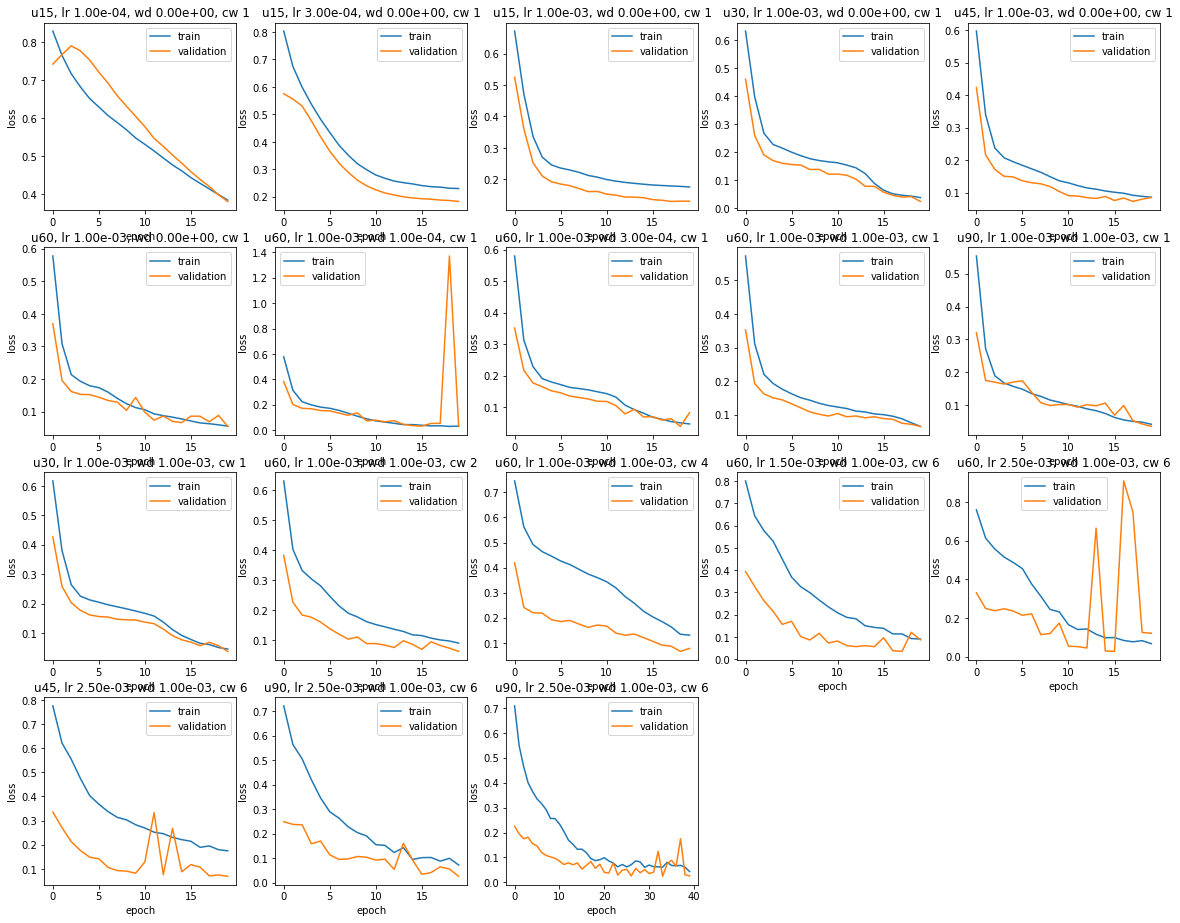

In [90]:
# plot losses
fig = plt.figure(figsize=(20, 20))
for i, history in enumerate(histories):
    ax = fig.add_subplot(5, 5, i+1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    # ax.plot(history.history['recall'])
    # ax.plot(history.history['val_recall'])
    title = f'u{ params_list[i]["units"]}, lr {params_list[i]["lr"]:.2e}, wd {params_list[i]["wd"]:.2e}, cw {params_list[i]["cw"][1]}'
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'recall', 'val_recall'])
plt.show()

# 1:   cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 256, epochs 100, Total params: 1,441
# 2:   cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,441
# 3:   cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,441
# 4:   cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.003, wd 0.0001, batch 512, epochs 30, Total params: 1,441
# 5:   cl 30, cl 30, cl 30, cl 30, cl 30 dense 1 sigmoid, lr 0.003, wd 0.0001, batch 512, epochs 30, Total params: 4,681
# 6:   cl 30, cl 30, cl 30, cl 30, cl 30 dense 1 sigmoid, lr 0.003, wd 0.001, batch 512, epochs 30, Total params: 4,681
# 7:   cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741
# 8:   cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741
# 9:   cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741, gama=2
# 10:  cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741, gama=1
# 11:  cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741
# 12:  cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741, gama=1class_weight={0:1, 1:20}
# 13:  cl 15, cl 15, cl 15, cl 15, cl 15, cl 15 dense 1 sigmoid, lr 0.001, wd 0.0001, batch 512, epochs 30, Total params: 1,741, gama=1class_weight={0:1, 1:2}

# # save the collection of histories to a file
# import pickle
# with open('histories.pickle', 'wb') as f:
#     pickle.dump(histories, f)

# # load the collection of histories from a file
# import pickle
# with open('histories.pickle', 'rb') as f:
#     histories_loaded = pickle.load(f)

# model.summary()